In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import make_scorer
from pandas.api.types import CategoricalDtype
from time import perf_counter
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
%matplotlib inline
sns.set_theme()

## Loding Data

Load the full car datset. Keep only a subset of columns useful for prediction.
Drop the samples with key features missing (mileage, age, price, power).
Drop the samples with clear input errors or very rare features
Split the df in train and test. 

In [3]:
file_path = os.path.join("..", "data", "usedcars_dataset.csv")
df_raw = pd.read_csv(file_path, sep=";", index_col="url")

In [4]:
final_col = ['Carburante',
                 'Carrozzeria',
                 'Chilometraggio',
                 'Cilindrata_cm3',
                 'Cilindri',
                 'Colore',
                 'Consumo_comb_L100km',
                 'Consumo_extraurb_L100km',
                 'Consumo_urb_L100km',
                 'Marce',
                 'Peso_a_vuoto_kg',
                 'Tagliandi_certificati',
                 'Tipo_di_cambio',
                 'Trazione',
                 'country',
                 'makeId',
                 'maker',
                 'model',
                 'modelOrModelLineId',
                 'potenza_kw',
                 'price',
                 'unico_proprietario',
                 'zip',
                 'age_years'
            ]

#    .drop(columns=[col for col in df_raw.columns if col not in final_col])
MAX_KM = 1e6
MAX_CV = 1000
MAX_AGE = 100
MAX_PRICE = 1e6
MIN_PRICE = 100
MAX_ENGSIZE = 1e4

In [5]:
df_clean = (df_raw.astype({'Anno':'datetime64[ns]', 'date':'datetime64[ns]'})
    .assign(age_years= lambda x: (x['date'] - x['Anno']) / np.timedelta64(1, 'Y'))
    .dropna(subset=['price', 'potenza_kw', 'age_years', 'Chilometraggio'])
    .query("~((age_years>@MAX_AGE or age_years < 0) \
                            or (potenza_cv > @MAX_CV or potenza_cv < 0) \
                            or (Chilometraggio>@MAX_KM or Chilometraggio < 0) \
                            or (price > @MAX_PRICE or price < @MIN_PRICE ) \
                            or (Cilindrata_cm3 > @MAX_ENGSIZE or Cilindrata_cm3 < 0 ) \
                )"
            )
)

In [6]:
df_train, df_test = train_test_split(df_clean, test_size=0.1)

## Loss Functions

In [7]:
def rmse_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def rmspe_loss(y_true, y_pred):
    return np.mean((y_true-y_pred)**2/y_true**2)**0.5

def mape_loss(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

rmse = make_scorer(rmse_loss, greater_is_better=False)
mae = make_scorer(mean_absolute_error, greater_is_better=False)
rmspe = make_scorer(rmspe_loss, greater_is_better=False)
mape = make_scorer(mape_loss, greater_is_better=False)

def show_losses(y_true, y_pred):
    d = {}
    d['rmse'] = [rmse_loss(y_true, y_pred)]
    d['rmspe'] = [rmspe_loss(y_true, y_pred)]
    d['mae'] = [mean_absolute_error(y_true, y_pred)]
    d['mape'] = [mape_loss(y_true, y_pred)]
    d['medae'] = [median_absolute_error(y_true, y_pred)]
    d['max_ae'] = [np.max(np.abs(y_true-y_pred))]
    d['max_pe'] = [np.max(np.abs(y_true-y_pred)/y_true)]
    
    df = pd.DataFrame(data=d)
    display(df)
    

## Baseline

Most simple baseline: using the mean/median as prediciton

In [8]:
price_mean = float(df_train['price'].mean())
price_median = float(df_train['price'].median())

In [9]:
print('Baseline Mean')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_mean)

print('Baseline Median')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_median)

Baseline Mean


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,26508.494383,2.020276,11215.529564,0.942425,8153.634073,888856.365927,41.287268


Baseline Median


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,26856.229367,1.565098,10574.556857,0.729483,6901.0,893000.0,33.0


## Manual exploration of models

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['price']), 
                                                    df_train['price'], 
                                                    test_size=0.2, random_state=42
                                                   )

In [11]:
num_features = ['age_years', 'potenza_kw', 'Chilometraggio', 'Cilindrata_cm3']
cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria', 'Carburante']

In [12]:
#Numerical features pipeline
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='drop'
)

## Linear Models

In [13]:
# Full model pipeline
lm_model = make_pipeline(
    preprocessor,
    LinearRegression()    
)

In [14]:
lm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [15]:
#Linear model predictions
y_train_lmp = lm_model.predict(X_train)
y_val_lmp = lm_model.predict(X_val)

In [16]:
print('Train Set')
show_losses(y_train, y_train_lmp)

print('Test Set')
show_losses(y_val, y_val_lmp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,13096.137329,1.532985,5983.438545,0.434651,3713.0,859281.25,221.429167


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,14127.27009,1.164603,6142.879467,0.443315,3753.125,661180.875,47.7215


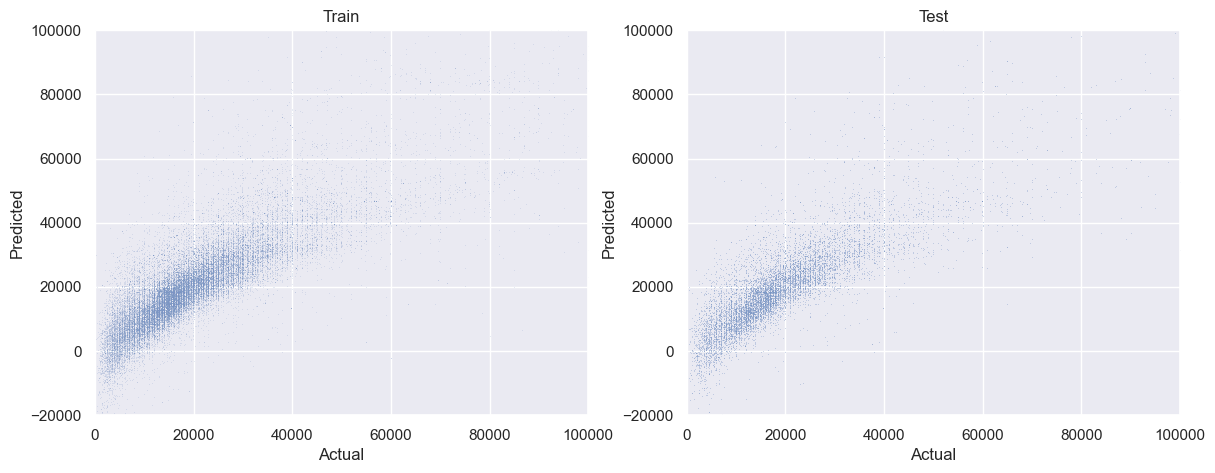

In [17]:
MAX_PRICE_PLOT = 1e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_lmp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[-2e4, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_lmp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[-2e4, MAX_PRICE_PLOT], title='Test');

## Random Forest Model

In [18]:
# Full model pipeline
rf_model = make_pipeline(
    preprocessor,
    RandomForestRegressor()    
)

In [19]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [22]:
#Random forest predictions
y_train_rfp = rf_model.predict(X_train)
y_val_rfp = rf_model.predict(X_val)

In [23]:
print('Train Set')
show_losses(y_train, y_train_rfp)

print('Test Set')
show_losses(y_val, y_val_rfp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,3441.941166,0.890074,917.466082,0.054562,366.18,228097.97,177.636656


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,10872.026912,0.421969,2553.897514,0.139069,973.94,596262.23,22.56564


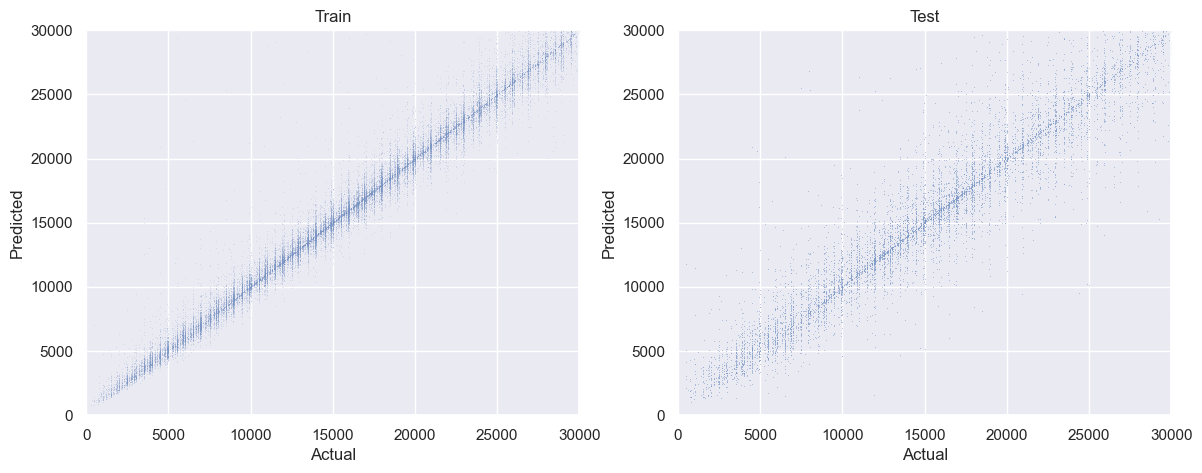

In [24]:
MAX_PRICE_PLOT = 0.3e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_rfp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_rfp, s=0.3, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Test');

## XGB Model

In [25]:
# Full model pipeline
xg_model = make_pipeline(
    preprocessor,
    XGBRegressor()    
)

In [26]:
xg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [27]:
#XGB predictions
y_train_xgp = xg_model.predict(X_train)
y_val_xgp = xg_model.predict(X_val)

In [28]:
print('Train Set')
show_losses(y_train, y_train_xgp)

print('Test Set')
show_losses(y_val, y_val_xgp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,3517.92102,0.482947,2261.155268,0.142799,1517.238281,141803.359375,78.249062


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,10521.77111,0.40573,2989.227676,0.165671,1584.044922,665373.390625,18.557287


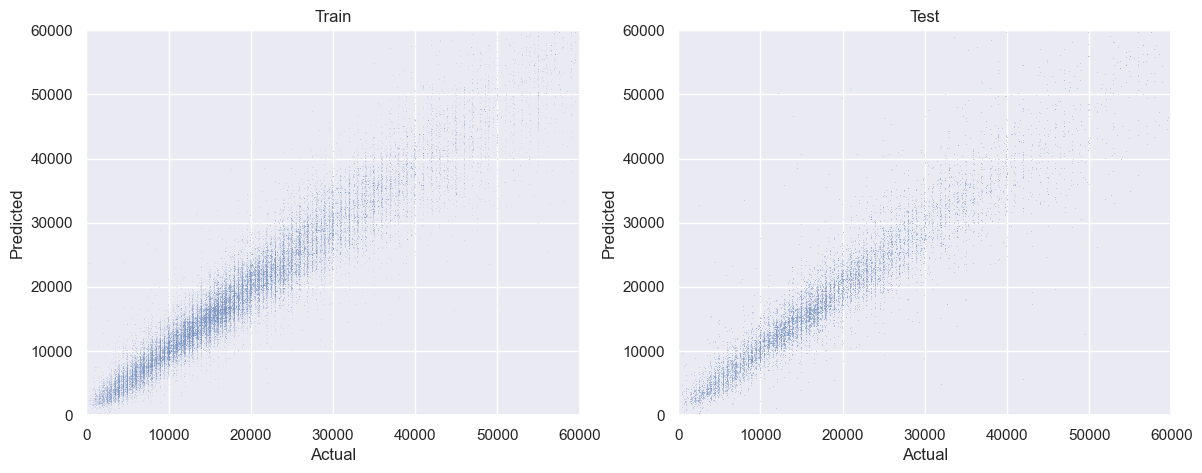

In [30]:
MAX_PRICE_PLOT = 0.6e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_xgp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_xgp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Test');

## Pycaret 

In [8]:
from pycaret.regression import *

In [9]:
df_raw.columns

Index(['Acconto', 'Anno', 'Carburante', 'Carrozzeria', 'Chilometraggio',
       'Cilindrata_cm3', 'Cilindri', 'Colore', 'Comfort',
       'Consumo_comb_L100km', 'Consumo_extraurb_L100km', 'Consumo_urb_L100km',
       'Emissioni_CO2_gKm', 'Extra', 'Intrattenimento__Media', 'Marce',
       'Peso_a_vuoto_kg', 'Porte', 'Posti', 'Prezzo_auto', 'Sicurezza',
       'Tagliandi_certificati', 'Tipo_di_cambio', 'Tipo_di_veicolo',
       'Trazione', 'city', 'country', 'countryCode', 'date', 'garanzia_mesi',
       'makeId', 'maker', 'model', 'modelOrModelLineId', 'modelVersionInput',
       'potenza_cv', 'potenza_kw', 'price', 'street', 'unico_proprietario',
       'zip'],
      dtype='object')

In [10]:
exp_reg_pc = setup(data = df_train, 
                   target = 'price', 
                   session_id=123,
                   normalize = True, transformation = True, transform_target = True,
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   feature_selection = True,
                   fold_shuffle=True,
                   numeric_features = ['Marce', 'Posti', 'Porte', 'Cilindri'],
                   ignore_features=['country', 'countryCode','date', 'street',
                                    'potenza_cv', 'Prezzo_auto',
                                    'makeId', 'modelOrModelLineId', 'Extra', 'Intrattenimento__Media',
                                    'Consumo_extraurb_L100km', 'Consumo_urb_L100km', 'Sicurezza', 'Colore',
                                   'garanzia_mesi', 'modelVersionInput', 'zip', 'Comfort', 'city', 'Anno'],
                   high_cardinality_features=['maker', 'model'],
#                   bin_numeric_features = ['Marce', 'Posti', 'Porte', 'Cilindri'],
                   numeric_imputation='median',
                   categorical_imputation='mode',
                   remove_outliers = True,
                   combine_rare_levels = True,
                   polynomial_features=True,
                   unknown_categorical_method='most_frequent'
                  )

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(53027, 42)"
3,Missing Values,True
4,Numeric Features,12
5,Categorical Features,9
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(35262, 36)"


In [11]:
sorted(get_config('X').columns)

['Acconto',
 'Carburante_Benzina',
 'Carburante_Diesel',
 'Carburante_GPL',
 'Carburante_Ibrida',
 'Carburante_Metano',
 'Carrozzeria_Altro',
 'Carrozzeria_Berlina',
 'Carrozzeria_Cabrio',
 'Carrozzeria_City Car',
 'Carrozzeria_Coupe',
 'Carrozzeria_Monovolume',
 'Carrozzeria_SUV/Fuoristrada',
 'Carrozzeria_Station Wagon',
 'Chilometraggio',
 'Cilindrata_cm3',
 'Cilindri',
 'Consumo_comb_L100km',
 'Emissioni_CO2_gKm',
 'Marce',
 'Peso_a_vuoto_kg',
 'Porte',
 'Posti',
 'Tagliandi_certificati_False',
 'Tipo_di_cambio_Automatico',
 'Tipo_di_cambio_Manuale',
 'Tipo_di_cambio_Semiautomatico',
 'Tipo_di_veicolo_KM0',
 'Trazione_Anteriore',
 'Trazione_Integrale',
 'Trazione_Posteriore',
 'age_years_Power2',
 'maker',
 'model',
 'potenza_kw',
 'unico_proprietario_False']

In [44]:
best = compare_models(n_select = 5, 
#                        include=['lr', 'ridge', 'knn', 'par', 'svm', 'rf', 'lightgbm', 'ada', 'xgboost', 'catboost'],
                        sort = 'MAE',
                        budget_time=30,
                        fold = 5
                     )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1862.3503,54176406.9137,6986.3489,0.8242,0.1907,0.1104,8.4800
rf,Random Forest Regressor,1963.4160,47996330.9147,6497.5814,0.8468,0.1903,0.1157,9.9060
catboost,CatBoost Regressor,2099.0237,46627634.8305,6478.3846,0.8489,0.1834,0.1224,5.9140
xgboost,Extreme Gradient Boosting,2137.1995,46835980.0000,6410.4781,0.8505,0.1901,0.1246,2.6740
lightgbm,Light Gradient Boosting Machine,2328.3535,54294372.9953,6936.6986,0.8260,0.1949,0.1320,1.0500
dt,Decision Tree Regressor,2683.8419,113519423.8846,10204.4592,0.5715,0.2691,0.1634,0.2980
gbr,Gradient Boosting Regressor,2905.7073,65652373.6765,7716.8431,0.7864,0.2265,0.1608,2.8840
knn,K Neighbors Regressor,2999.5531,75306562.2516,8363.6391,0.7513,0.2616,0.1785,5.5160
huber,Huber Regressor,3675.4288,113363613.3264,10347.4370,0.6207,0.2912,0.2092,0.7520
br,Bayesian Ridge,3707.1876,106318618.4477,9987.1181,0.6462,0.2885,0.2121,0.1280


In [12]:
save_config(os.path.join('models', 'pyc_config.pkl'))

### Exploring catboost and xgboost

In [13]:
ctb = create_model('catboost', fold=10)
tuned_ctb = tune_model(ctb, n_iter = 25, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1851.2200,19752705.2505,4444.4016,0.9225,0.1999,0.1411
1,1949.5567,77154273.4850,8783.7505,0.7167,0.1841,0.1108
2,1799.5045,14041533.4820,3747.2034,0.9287,0.1784,0.1151
3,1927.7458,25096118.7065,5009.6026,0.8750,0.1874,0.1134
4,1821.2088,15587825.9861,3948.1421,0.9265,0.1844,0.1139
5,1816.6502,19224862.3867,4384.6166,0.9039,0.1833,0.1125
6,1854.7443,19433799.4012,4408.3783,0.9072,0.1856,0.1155
7,1755.1505,20186814.2164,4492.9739,0.8982,0.1832,0.1126
8,1912.1693,20702274.7213,4549.9752,0.8993,0.1638,0.1073


In [14]:
xgb = create_model('xgboost', fold=10)
tuned_xgb = tune_model(xgb, n_iter = 25, optimize='MAE')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1881.6681,19227316.0000,4384.8965,0.9246,0.1952,0.1377
1,1974.3047,72395688.0000,8508.5654,0.7342,0.1757,0.1096
2,1817.8176,12674036.0000,3560.0613,0.9356,0.1723,0.1135
3,1898.9617,20150194.0000,4488.8970,0.8997,0.1803,0.1106
4,1887.6727,14493637.0000,3807.0510,0.9316,0.1806,0.1170
5,1824.4929,19022406.0000,4361.4683,0.9049,0.1816,0.1122
6,1899.7737,20105196.0000,4483.8818,0.9040,0.1850,0.1185
7,1749.3772,17730318.0000,4210.7383,0.9106,0.1750,0.1115
8,1940.8666,18886020.0000,4345.8047,0.9081,0.1600,0.1072


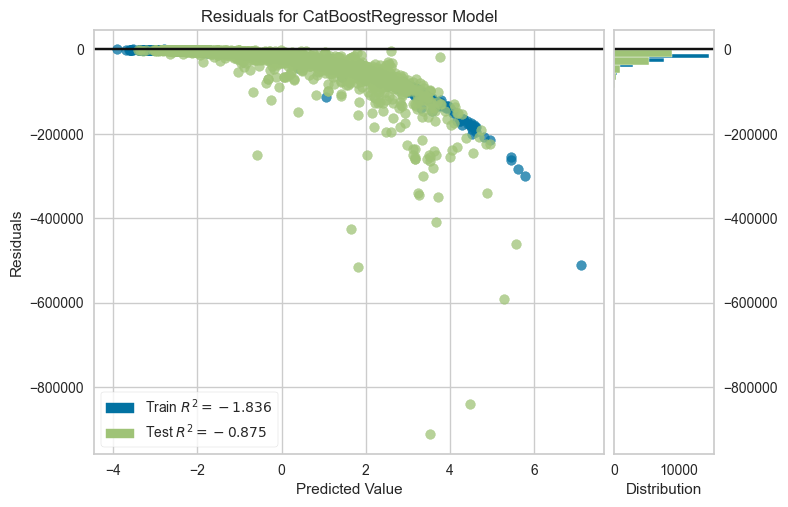

In [17]:
plot_model(tuned_ctb, plot='residuals')

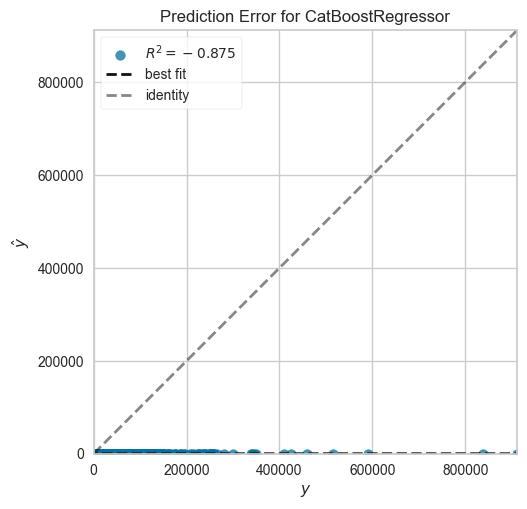

In [18]:
plot_model(tuned_ctb, plot = 'error')

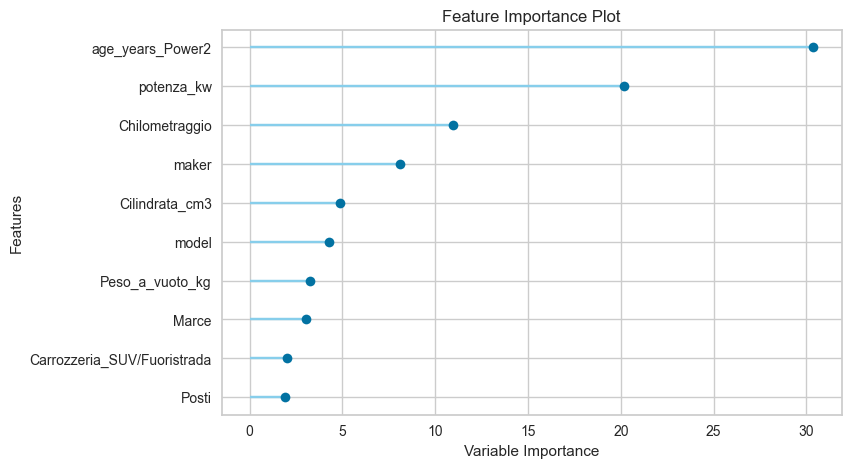

In [19]:
plot_model(tuned_ctb, plot='feature')

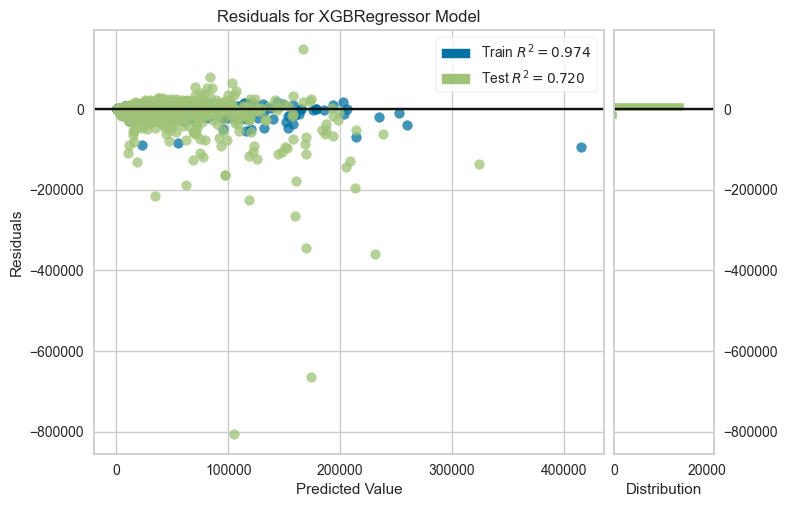

In [20]:
plot_model(tuned_xgb, plot='residuals')

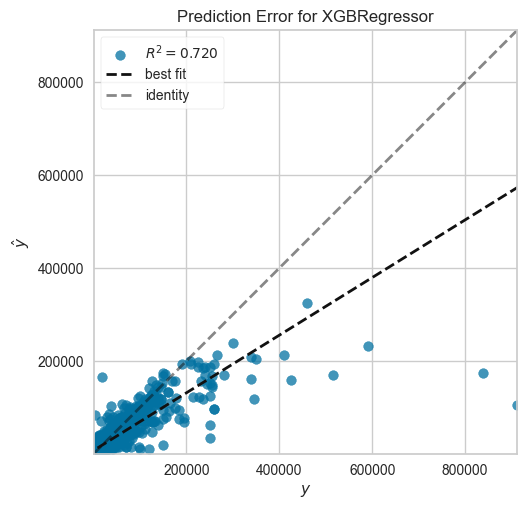

In [21]:
plot_model(tuned_xgb, plot = 'error')

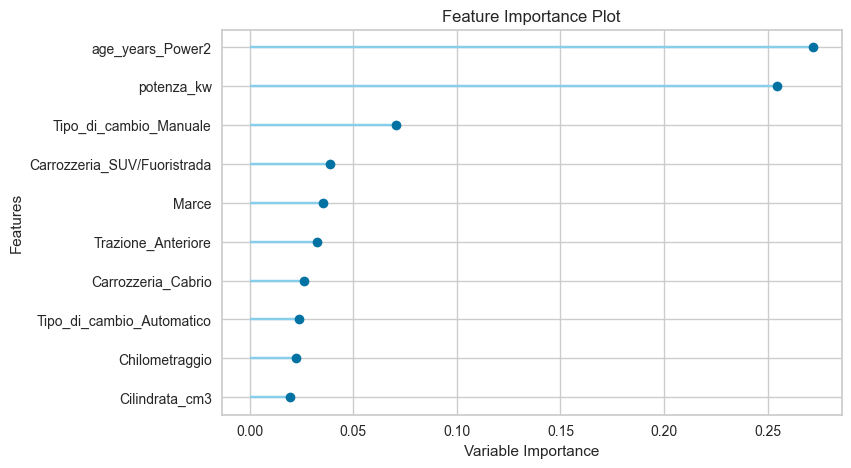

In [22]:
plot_model(tuned_xgb, plot='feature')

In [23]:
final_ctb = finalize_model(tuned_ctb)
final_xgb = finalize_model(tuned_xgb)

In [26]:
save_model(final_ctb,os.path.join('models', 'Final CatBoost Model'))
save_model(final_xgb,os.path.join('models', 'Final XGBoost Model'))

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['country', 'countryCode',
                                                        'date', 'street',
                                                        'potenza_cv',
                                                        'Prezzo_auto', 'makeId',
                                                        'modelOrModelLineId',
                                                        'Extra',
                                                        'Intrattenimento__Media',
                                                        'Consumo_extraurb_L100km',
                                                        'Consumo_urb_L100km',
                                                        'Sicurezza', 'Colore',
                                                      

In [27]:
load_model(os.path.join('models', 'Final CatBoost Model'))
load_model(os.path.join('models', 'Final CatBoost Model'))


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['country', 'countryCode',
                                                       'date', 'street',
                                                       'potenza_cv',
                                                       'Prezzo_auto', 'makeId',
                                                       'modelOrModelLineId',
                                                       'Extra',
                                                       'Intrattenimento__Media',
                                                       'Consumo_extraurb_L100km',
                                                       'Consumo_urb_L100km',
                                                       'Sicurezza', 'Colore',
                                                       'garanzia_mes

In [28]:
train_prediction = predict_model(final_ctb, data=df_train)
test_prediction = predict_model(final_ctb, data=df_test)
train_prediction = predict_model(final_xgb, data=df_train)
test_prediction = predict_model(final_xgb, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1232.8947,6862903.7378,2619.7144,0.9848,0.0941,0.0662


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2274.3188,104441172.5280,10219.6464,0.8004,0.1762,0.1058


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1560.1722,17221299.5639,4149.8554,0.9619,0.1177,0.0825


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,2334.2618,109428562.0453,10460.8108,0.7909,0.1781,0.1094


In [29]:
pred_by_maker = (train_prediction.assign(pred_error= lambda x: np.abs(x['Label']-x['price']))
                .loc[:, ['maker', 'pred_error', 'price']]
                .groupby(by='maker')
                .aggregate( count=pd.NamedAgg(column="maker", aggfunc="count"),
                            med_price=pd.NamedAgg(column="price", aggfunc="median"),
                            err_min=pd.NamedAgg(column="pred_error", aggfunc="min"),
                            err_max=pd.NamedAgg(column="pred_error", aggfunc="max"),
                            err_mean=pd.NamedAgg(column="pred_error", aggfunc="mean"),
                            err_median=pd.NamedAgg(column="pred_error", aggfunc="median"),
                            err_std=pd.NamedAgg(column="pred_error", aggfunc="std")
                        )
                .sort_values(by='err_median', ascending=False)
                )

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pred_by_maker)

,count,med_price,err_min,err_max,err_mean,err_median,err_std
maker,,,,,,,
Lamborghini,14,318900.0,4236.296875,53774.687500,24100.553571,18181.265625,18585.901662
Maxus,1,36222.0,12146.185547,12146.185547,12146.185547,12146.185547,NaN
MAN,1,27480.0,8769.621094,8769.621094,8769.621094,8769.621094,NaN
Ferrari,66,226000.0,805.578125,355075.937500,26886.207978,8675.703125,50214.737411
Alpine,2,45250.0,6216.421875,8052.753906,7134.587891,7134.587891,1298.482832
Caterham,1,64500.0,6959.812500,6959.812500,6959.812500,6959.812500,NaN
Caravans-Wohnm,1,31500.0,6503.261719,6503.261719,6503.261719,6503.261719,NaN
Lotus,5,74990.0,3682.800781,14520.562500,7097.882812,5939.820312,4305.231758
McLaren,7,240000.0,199.484375,14463.500000,7384.466518,5451.171875,5999.162518


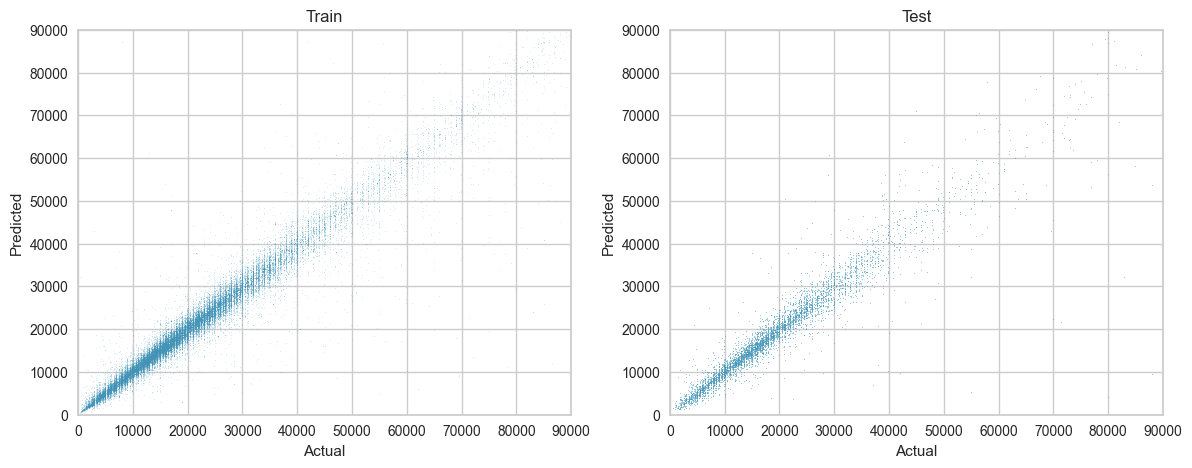

In [29]:
MAX_PRICE_PLOT = 0.9e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(train_prediction, x='price', y='Label', s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(test_prediction, x='price', y='Label', s=0.3, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Test');